# Expressions, lazy mode and logging queries

So far, we have seen Ibis in interactive mode. Interactive mode (also known as eager mode) makes Ibis return the
results of an operation immediately.

In most cases, instead of using interactive mode, it makes more sense to use the default lazy mode.
In lazy mode, Ibis won't be executing the operations automatically, but instead, will generate an
expression to be executed at a later time.

Let's see this in practice, starting with the same example as in previous tutorials - the geography database.

In [1]:
import os
import ibis


connection = ibis.sqlite.connect(os.path.join('data', 'geography.db'))
countries = connection.table('countries')

In previous tutorials, we set interactive mode to `True`, and we obtained the result
of every operation.

In [2]:
ibis.options.interactive = True

countries['name', 'continent', 'population'].limit(3)

                   name continent  population
0               Andorra        EU       84000
1  United Arab Emirates        AS     4975593
2           Afghanistan        AS    29121286

But now let's see what happens if we leave the `interactive` option to `False` (the default),
and we operate in lazy mode.

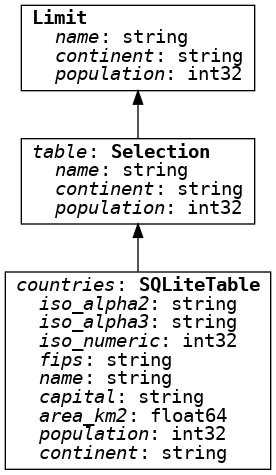

In [3]:
ibis.options.interactive = False

countries['name', 'continent', 'population'].limit(3)

What we find is the graph of the expressions that would return the desired result instead of the result itself.

Let's analyze the expressions in the graph:

- We query the `countries` table (all rows and all columns)
- We select the `name`, `continent` and `population` columns
- We limit the results to only the first `3` rows

Now consider that the data is in a database, possibly in a diferent host than the one executing Ibis.
Also consider that the results returned to the user need to be moved to the memory of the host executing Ibis.

When using interactive (or eager) mode, if we perform one operation at a time, we would do:

- We would move all the rows and columns from the backend (database, big data system, etc.) into memory
- Once in memory, we would discard all the columns but `name`, `continent` and `population`
- After that, we would discard all the rows, except the first `3`

This is not very efficient. If you consider that the table can have millions of rows, backed by a
big data system like Spark or Impala, this may not even be possible (not enough memory to load all the data).

The solution is to use lazy mode. In lazy mode, instead of obtaining the results after each operation,
we build an expression (a graph) of all the operations that need to be done. After all the operations
are recorded, the graph is sent to the backend which will perform the operation in an efficient way - only
moving to memory the required data.

You can think of this as writing a shopping list and requesting someone to go to the supermarket and buy
everything you need once the list is complete. As opposed as getting someone to bring all the products of
the supermarket to your home and then return everything you don't want.

Let's continue with our example, save the expression in a variable `countries_expression`, and check its type.

In [4]:
countries_expression = countries['name', 'continent', 'population'].limit(3)
type(countries_expression)

ibis.expr.types.TableExpr

The type is an Ibis `TableExpr`, since the result is a table (in a broad way, you can consider it a dataframe).

Now we have our query instructions (our expression, fetching only 3 columns and 3 rows) in the variable `countries_expression`.

At this point, nothing has been requested from the database. We have defined what we want to extract, but we didn't
request it from the database yet. We can continue building our expression if we haven't finished yet. Or once we
are done, we can simply request it from the database using the method `.execute()`.

In [5]:
countries_expression.execute()

,name,continent,population
0,Andorra,EU,84000
1,United Arab Emirates,AS,4975593
2,Afghanistan,AS,29121286


We can build other types of expressions, for example, one that instead of returning a table,
returns a columns.

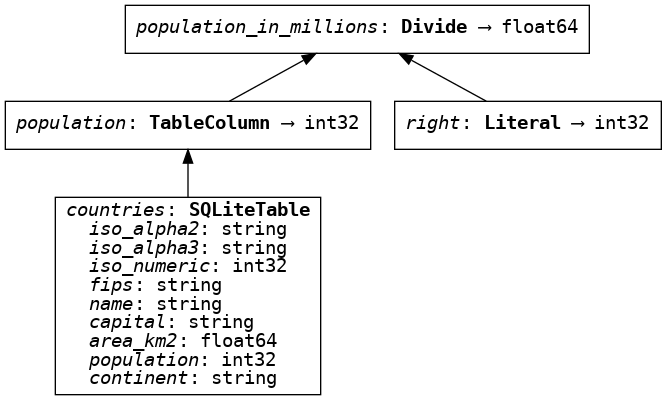

In [6]:
population_in_millions = (countries['population'] / 1_000_000).name('population_in_millions')
population_in_millions

If we check its type, we can see how it is a `FloatingColumn` expression.

In [7]:
type(population_in_millions)

ibis.expr.types.FloatingColumn

We can combine the previous expression to be a column of a table expression.

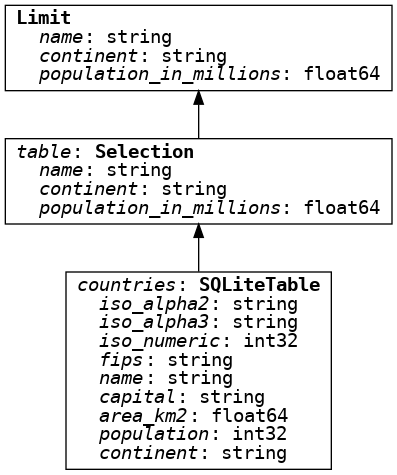

In [8]:
countries['name', 'continent', population_in_millions].limit(3)

Since we are in lazy mode (not interactive), those expressions don't request any data from the database
unless explicitly requested with `.execute()`.

## Logging queries

For SQL backends (and for others when it makes sense), the query sent to the database can be logged.
This can be done by setting the `verbose` option to `True`.

In [9]:
ibis.options.verbose = True

countries['name', 'continent', population_in_millions].limit(3).execute()

SELECT t0.name, t0.continent, t0.population / CAST(? AS REAL) AS population_in_millions 
FROM base.countries AS t0
 LIMIT ? OFFSET ?


,name,continent,population_in_millions
0,Andorra,EU,0.084000
1,United Arab Emirates,AS,4.975593
2,Afghanistan,AS,29.121286


By default, the logging is done to the terminal, but we can process the query with a custom function.
This allows us to save executed queries to a file, save to a database, send them to a web service, etc.

For example, to save queries to a file, we can write a custom function that given a query, saves it to a
log file.

In [10]:
import os
import datetime

def log_query_to_file(query):
    """
    Log queries to `data/tutorial_queries.log`.
    
    Each file is a query. Line breaks in the query are represented with the string '\n'.
    
    A timestamp of when the query is executed is added.
    """
    fname = os.path.join('data', 'tutorial_queries.log')
    query_in_a_single_line = query.replace('\n', r'\n')
    with open(fname, 'a') as f:
        f.write(f'{datetime.datetime.now()} - {query_in_a_single_line}\n')

Then we can set the `verbose_log` option to the custom function, execute one query,
wait one second, and execute another query.

In [11]:
import time

ibis.options.verbose_log = log_query_to_file

countries.execute()
time.sleep(1.)
countries['name', 'continent', population_in_millions].limit(3).execute()

,name,continent,population_in_millions
0,Andorra,EU,0.084000
1,United Arab Emirates,AS,4.975593
2,Afghanistan,AS,29.121286


This has created a log file in `data/tutorial_queries.log` where the executed queries have been logged.

In [12]:
!cat data/tutorial_queries.log

2020-07-02 17:51:02.760861 - SELECT t0.iso_alpha2, t0.iso_alpha3, t0.iso_numeric, t0.fips, t0.name, t0.capital, t0.area_km2, t0.population, t0.continent \nFROM base.countries AS t0\n LIMIT ? OFFSET ?
2020-07-02 17:51:03.779023 - SELECT t0.name, t0.continent, t0.population / CAST(? AS REAL) AS population_in_millions \nFROM base.countries AS t0\n LIMIT ? OFFSET ?
